### Income classification : random forest classifier

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
data = pd.read_csv('adult.csv')
df = data.copy()
display(df.head(10))

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
6,29,?,227026,HS-grad,9,Never-married,?,Unmarried,Black,Male,0,0,40,United-States,<=50K
7,63,Self-emp-not-inc,104626,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,>50K
8,24,Private,369667,Some-college,10,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,<=50K
9,55,Private,104996,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,<=50K


In [ ]:
# df['occupation'].value_counts().plot(kind='bar')
# df['hours-per-week'].value_counts()
# df['occupation'][df['hours-per-week'] > 80].value_counts().plot(kind='bar')

# plot the income distribution of those who with hours-per-week by the occupation and hours-per-week
# sns.catplot(x='occupation', y='hours-per-week', hue='income', data=df[df['hours-per-week'] > 80], kind='bar')
# plt.xticks(rotation=90)
# plt.show()

In [ ]:
print('workclass',df.workclass.unique())
print('education',df.education.unique())
print('marital-status',df['marital-status'].unique())
print('occupation',df.occupation.unique())
print('relationship',df.relationship.unique())
print('race',df.race.unique())
# print('gender',df.gender.unique())
# print('native-country',df['native-country'].unique())

workclass ['Private' 'Local-gov' '?' 'Self-emp-not-inc' 'Federal-gov' 'State-gov'
 'Self-emp-inc' 'Without-pay' 'Never-worked']
education ['11th' 'HS-grad' 'Assoc-acdm' 'Some-college' '10th' 'Prof-school'
 '7th-8th' 'Bachelors' 'Masters' 'Doctorate' '5th-6th' 'Assoc-voc' '9th'
 '12th' '1st-4th' 'Preschool']
marital-status ['Never-married' 'Married-civ-spouse' 'Widowed' 'Divorced' 'Separated'
 'Married-spouse-absent' 'Married-AF-spouse']
occupation ['Machine-op-inspct' 'Farming-fishing' 'Protective-serv' '?'
 'Other-service' 'Prof-specialty' 'Craft-repair' 'Adm-clerical'
 'Exec-managerial' 'Tech-support' 'Sales' 'Priv-house-serv'
 'Transport-moving' 'Handlers-cleaners' 'Armed-Forces']
relationship ['Own-child' 'Husband' 'Not-in-family' 'Unmarried' 'Wife' 'Other-relative']
race ['Black' 'White' 'Asian-Pac-Islander' 'Other' 'Amer-Indian-Eskimo']


<Axes: xlabel='count', ylabel='income'>

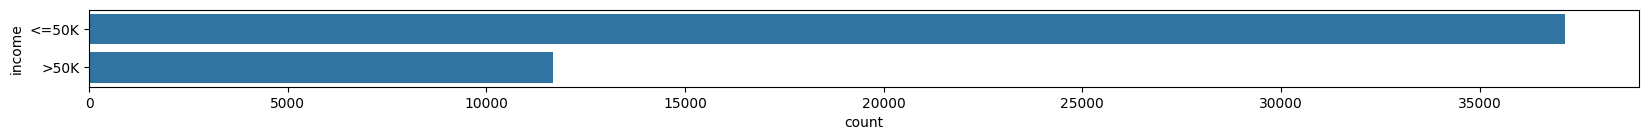

In [ ]:
plt.figure(figsize=(20, 1))
# plt.style.use('seaborn-ticks')
sns.countplot(y='income', data=df)

In [ ]:
df.dtypes.value_counts()

object    9
int64     6
dtype: int64

In [ ]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, RobustScaler, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

In [ ]:
df = df.replace('?', np.nan)

y = df['income']
X = df.drop(['income', 'educational-num'], axis=1)

num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(include='object').columns.tolist()
cat_cols = [col for col in cat_cols if col != 'native-country']
capital_cols = ['capital-gain', 'capital-loss']
num_cols = [col for col in num_cols if col not in capital_cols]


In [ ]:
df.isnull().sum()

age                   0
workclass          2799
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64

In [ ]:
X.isna().sum()

age                  0
workclass         2799
fnlwgt               0
education            0
marital-status       0
occupation        2809
relationship         0
race                 0
gender               0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
dtype: int64

In [ ]:
countries = X['native-country'].unique()
country_dict = {country: i for i, country in enumerate(countries)}


def encode_country(X):
        encoded_val = pd.Series(X.squeeze()).map(country_dict)
        return pd.DataFrame(encoded_val)

def decode_country(X):
    X = pd.Series(X.squeeze()).map({v: k for k, v in country_dict.items()})
    return X


country_encoder = FunctionTransformer(encode_country, decode_country, check_inverse=False)

In [ ]:
country_pipeline = make_pipeline(
        SimpleImputer(strategy='most_frequent', missing_values=np.nan),
        country_encoder
    )

cat_pipeline = make_pipeline(
        SimpleImputer(strategy='constant', fill_value='unknown'),
        OrdinalEncoder()
    )

num_pipeline = make_pipeline(
        SimpleImputer(strategy='median'),
        StandardScaler()
    )

capital_pipeline = make_pipeline(
        RobustScaler()
    )

preprocessor = make_column_transformer(
        (country_pipeline, ['native-country']),
        (cat_pipeline, cat_cols),
        (num_pipeline, num_cols),
        (capital_pipeline, capital_cols)
    )



In [ ]:
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('functiontransformer',
                                                  FunctionTransformer(check_inverse=False,
                                                                      func=<function encode_country at 0x782438cce7a0>,
                                                                      inverse_func=<function decode_country at 0x782435248b80>))]),
                                 ['native-country']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimput...
                                                  OrdinalEncoder())]),
                                 ['workclass', 'education', 'marital-status',
                                  'occupation', 'relationship', 'race',
                                  'gender']),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['age', 'fnlwgt', 'hours-per-week']),
                                ('pipeline-4',
                                 Pipeline(steps=[('robustscaler',
                                                  RobustScaler())]),
                                 ['capital-gain', 'capital-loss'])])

In [ ]:
y_encoded = LabelEncoder().fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=2)

In [ ]:
print(y_train.shape, X_train.shape)

(39073,) (39073, 13)


In [ ]:
model_pipeline = make_pipeline(
    preprocessor,
    RandomForestClassifier(random_state=0)
)

param_grid = {
    # 'columntransformer__pipeline-1__knnimputer__n_neighbors': [5, 7, 10],
    'randomforestclassifier__n_estimators': [100, 200, 300],
}

grid = GridSearchCV(model_pipeline, param_grid, cv=5, error_score='raise')

grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(check_inverse=False,
                                                                                                              func=<function encode_country at 0x782438cce7a0>,
                                                                                                              inverse_func=<function decode_country...
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'fnlwgt',
                                                                          'hours-per-week']),
                                                                        ('pipeline-4',
                                                                         Pipeline(steps=[('robustscaler',
                                                                                          RobustScaler())]),
                                                                         ['capital-gain',
                                                                          'capital-loss'])])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=0))]),
             param_grid={'randomforestclassifier__n_estimators': [100, 200,
                                                                  300]})

In [ ]:
grid.best_params_

{'randomforestclassifier__n_estimators': 300}

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Predict on the test set
y_pred = grid.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8576108097041663
Recall: 0.6052287581699346
F1 Score: 0.6663468457663709
